<a href="https://colab.research.google.com/github/mesteesee/cnnlstm/blob/main/cnnlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新增區段

In [18]:
import shutil
from pathlib import Path
import numpy as np
p=Path('cnnlstm')
if(p.exists()):
  shutil.rmtree('cnnlstm')
!git clone https://github.com/mesteesee/cnnlstm.git #Clone the model from github

Cloning into 'cnnlstm'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 21.72 KiB | 3.10 MiB/s, done.
Resolving deltas: 100% (4/4), done.


# 新增區段

Epoch 1/1000
9/9 [==============================] - 6s 134ms/step - loss: 6.8108 - output1_loss: 3.4917 - output2_loss: 3.3190 - output1_accuracy: 0.0455 - output2_accuracy: 0.1084 - val_loss: 6.7298 - val_output1_loss: 3.4558 - val_output2_loss: 3.2740 - val_output1_accuracy: 0.1944 - val_output2_accuracy: 0.4583
Epoch 2/1000
9/9 [==============================] - 0s 10ms/step - loss: 6.7066 - output1_loss: 3.4535 - output2_loss: 3.2531 - output1_accuracy: 0.1084 - output2_accuracy: 0.3566 - val_loss: 6.4758 - val_output1_loss: 3.3485 - val_output2_loss: 3.1273 - val_output1_accuracy: 0.1667 - val_output2_accuracy: 0.4583
Epoch 3/1000
9/9 [==============================] - 0s 11ms/step - loss: 6.4452 - output1_loss: 3.3713 - output2_loss: 3.0739 - output1_accuracy: 0.1014 - output2_accuracy: 0.3636 - val_loss: 5.8695 - val_output1_loss: 3.0921 - val_output2_loss: 2.7774 - val_output1_accuracy: 0.1667 - val_output2_accuracy: 0.4583
Epoch 4/1000
9/9 [==============================] - 0s

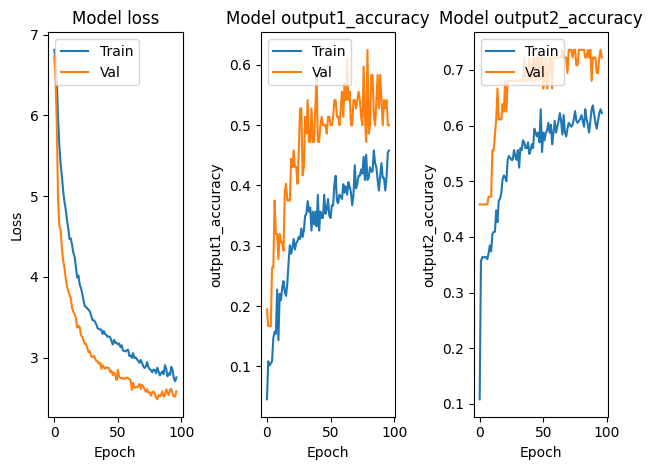

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import h5py

# 讀取資料
train_data = pd.read_parquet('cnnlstm/data/train.parquet')
test_data = pd.read_parquet('cnnlstm/data/val.parquet')
encoder = pd.read_parquet('cnnlstm/data/encoder.parquet')


# 資料預處理
def preprocess_data(train_data, test_data, encoder):
    graph_encoder = {row['圖號1']: i for i, row in encoder.iterrows()}
    graph_encoder2 = {row['圖號2']: i for i, row in encoder.iterrows()}

    encoder = encoder.drop(columns=['圖號1','圖號2'])

    # 建立類別到編碼的映射字典
    category_maps = {}
    for col in encoder.columns:
        category_maps[col] = {row[col]: i for i, row in encoder.iterrows()}

    # 使用編碼字典對類別特徵進行編碼
    for col in category_maps:
        train_data[col] = train_data[col].map(category_maps[col])
        test_data[col] = test_data[col].map(category_maps[col])

    return train_data, test_data, graph_encoder, graph_encoder2, category_maps

# 呼叫資料預處理函數
train_data, test_data, graph_encoder, graph_encoder2, category_maps = preprocess_data(train_data, test_data, encoder)

# 提取特徵和標籤
X_train = train_data[['蓋材', '罐材', '罐型','蓋厚度', '罐厚度']]
y_train = [train_data['圖號1'], train_data['圖號2']]
X_test = test_data[['蓋材', '罐材', '罐型','蓋厚度', '罐厚度']]
y_test = [test_data['圖號1'], test_data['圖號2']]


# 圖號編碼
y_train[0] = y_train[0].map(graph_encoder)
y_test[0] = y_test[0].map(graph_encoder)
y_train[1] = y_train[1].map(graph_encoder2)
y_test[1] = y_test[1].map(graph_encoder2)

num_classes1 = len(y_train[0].unique())
num_classes2 = len(y_train[1].unique())

X_train = X_train.values[:, np.newaxis, :]
X_test = X_test.values[:, np.newaxis, :]


# 建立多輸出模型
def build_multi_output_model(input_shape, num_classes1, num_classes2):
    shared_input = layers.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(shared_input)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.TimeDistributed(layers.Dense(20))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation='relu')(x)

    # 第一个输出层
    output1 = layers.Dense(num_classes1, activation='softmax', name='output1')(x)

    # 第二个输出层
    output2 = layers.Dense(num_classes2, activation='softmax', name='output2')(x)

    model = keras.Model(inputs=shared_input, outputs=[output1, output2])

    return model

# 建立模型
input_shape = X_train.shape[1:]
model = build_multi_output_model(input_shape, num_classes1, num_classes2)
# 定義回調以提前停止訓練
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# 編譯模型
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss={'output1': 'sparse_categorical_crossentropy', 'output2': 'sparse_categorical_crossentropy'},
  metrics={'output1': 'accuracy', 'output2': 'accuracy'},
)



# 訓練模型
epochs = 1000
batch_size = 32

history = model.fit(
  X_train, {'output1': y_train[0], 'output2': y_train[1]},
  epochs=epochs,
  batch_size=batch_size,
  validation_data=(X_test, {'output1': y_test[0], 'output2': y_test[1]}),
  callbacks=[early_stopping]
)

# 評估模型
test_results = model.evaluate(X_test, {'output1': y_test[0], 'output2': y_test[1]})

# 獲取損失和準確度
test_loss = round(test_results[0],2)
test_acc_output1 = round(test_results[3],2)
test_acc_output2 = round(test_results[4],2)

# 印出測試損失和準確度
print("Test Loss:", test_loss)
print("Test Accuracy (1#):", test_acc_output1)
print("Test Accuracy (2#):", test_acc_output2)


# 畫訓練曲線
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.subplot(1, 3, 2)
plt.plot(history.history['output1_accuracy'])
plt.plot(history.history['val_output1_accuracy'])
plt.title('Model output1_accuracy')
plt.ylabel('output1_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.subplot(1, 3, 3)
plt.plot(history.history['output2_accuracy'])
plt.plot(history.history['val_output2_accuracy'])
plt.title('Model output2_accuracy')
plt.ylabel('output2_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

# 儲存模型
model.save('cnnlstm.h5')
